In [1]:
!python -V
'Code example'

Python 3.11.5


'Code example'

# 1.- Librerias

In [23]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
#!pip install pyarrow

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(pd.__version__)
print(sklearn.__version__)

2.0.3
1.2.2


# Pregunta 1

In [15]:
# Cargo la base de green trip para enero 2021
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
nume_cols = len(df.columns)
print(nume_cols)
df.head(2)


19


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0


# Pregunta 2

In [16]:
# Calculamos la duracion del viaje en taxi en minutos
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df_std = df.duration.std()

print(f'La desviación estandar es: {df_std}')

La desviación estandar es: 42.594351241920904


# Pregunta 3

In [17]:
# Revisamos la distribucion de los datos para la duracion
print(df.duration.describe(percentiles=[0.95, 0.98, 0.99]))

nume_without_outliers = ((df.duration >= 1) & (df.duration <= 60)).mean()
print(f'% Data entre 1 y 60: {np.round(nume_without_outliers*100, 2)}% registros')

df = df[(df.duration >= 1) & (df.duration <= 60)]

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64
% Data entre 1 y 60: 98.12% registros


# Pregunta 4

In [20]:
# Variables categoricas y numericas que usaremos
categorical = ['PULocationID', 'DOLocationID']

# Transformamos las variables categoricas a tipo 'str'
df[categorical] = df[categorical].astype(str)

# Almacenamos las variables en una lista compuesta por diccionarios
train_dicts = df[categorical].to_dict(orient='records')

# Creamos nuetsra instancia de DictVectorizer
dv = DictVectorizer()
# Transformamos nuestra lista de diccionarios en una matriz dispersa que se le aplico One Hot Enconding a las variables categoricas
X_train = dv.fit_transform(train_dicts)

shape_df = X_train.shape
print(f'El numero de columnas de la matriz dispersa es: {shape_df[1]}')

El numero de columnas de la matriz dispersa es: 515


# Pregunta 5

In [21]:
# Definimos nuestra variable target
target = 'duration'
y_train = df[target].values

RMSE Train: 7.649262055538092


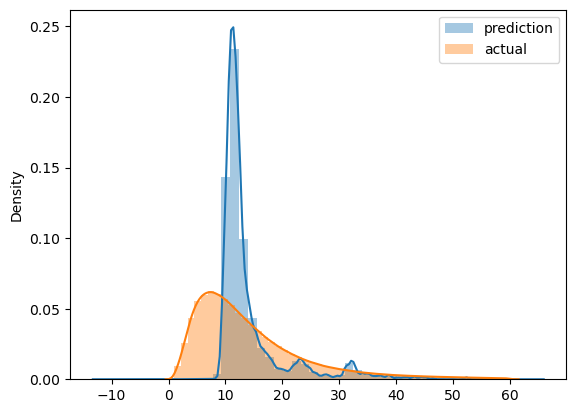

In [24]:
# Creamos la instancia para el modelo de regresion lineal
lr = LinearRegression()
# Ajustamos el modelo con nuestra informacion de entrenamiento
lr.fit(X_train, y_train)

# Calculamos el MSE
y_pred = lr.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE Train: {rmse_train}')
# Revisamos la distribucion de la predicciones y valores reales
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend(); plt.show()

## *Funcion para replicar procesamiento*

In [25]:
# Creamos una funcion que aplique los pasos de limpieza que realizamos anteriormente
def read_dataframe(filename):
    # Carga de base
    if filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    # Limpieza
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

# Pregunta 6

In [26]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [27]:
# Revisamos el tamaño de las bases de entrenamiento y validacion
len(df_train), len(df_val)

(3009173, 2855951)

In [28]:
categorical = ['PULocationID', 'DOLocationID']

# Aplicamos la instancia DictVectorizer a la data de entrenamiento y validacion
dv = DictVectorizer()
train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical].to_dict(orient='records')
X_valid = dv.transform(val_dicts)

In [29]:
# Definimos nuestra target para entrenamiento y validacion
target = 'duration'
y_train = df_train[target].values
y_valid = df_val[target].values

In [30]:
# Creamos y ajustamos el modelo de regresion a nuestra data de entrenamiento
lr = LinearRegression()
lr.fit(X_train, y_train)

# Validamos su performance en nuestra data de validacion
y_pred_train = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print(f'MSE Train: {rmse_train}')
print(f'MSE Valid: {rmse_valid}')

MSE Train: 7.649262055538092
MSE Valid: 7.811816386688629
